# Using Prophet For Crypto Price Forecasting

In this notebook, we use [Facebook's Prophet ](https://facebook.github.io/prophet/) to forecast Bitcoin's future price. Along the way, we use additional information about the Bitcoin network to improve our predictions. As a bonus, we will also predict Ethereum's price.

**Disclaimer**: the work in this notebook should not be be used in making financial decisions. Please understand the risks involve when trading cryptocurrencies or any financial instrument.

In [1]:
import math
import os
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from fbprophet import Prophet

from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

plt.rcParams["figure.figsize"] = (20, 10)

Importing plotly failed. Interactive plots will not work.


In [2]:
# convenience functions
def calculate_performance_metrics(y_true, y_predicted):
    explained_variance = r2_score(y_true, y_predicted)
    rmse = mean_squared_error(y_true, y_predicted, squared=False)
    print(f"Explained variance: {explained_variance}")
    print(f"RMSE: {rmse}")
    
    
def set_nonnegative_forecasts(forecast):
    forecast.loc[forecast["yhat"] < 0, "yhat"] = 0
    forecast.loc[forecast["yhat_lower"] < 0, "yhat_lower"] = 0
    forecast.loc[forecast["yhat_upper"] < 0, "yhat_upper"] = 0    

    
def clean_google_trends_data(df, start_date, max_date):
    trends = df.copy()
    trends["Date"] = pd.to_datetime(trends["Month"], format="%Y-%m")
    trends.drop("Month", axis=1, inplace=True)

    # ensure maximum date matches up with price data
    trends = trends.loc[trends["Date"] >= start_date]
    trends = pd.concat(
        [trends, pd.DataFrame(data={"Date": [max_date], "Interest": [np.NaN]})],
        ignore_index=True,
    )

    # perform linear interpolation
    trends = trends.set_index("Date")
    trends = trends.resample("D").mean()
    trends = trends.interpolate()
    trends = trends.reset_index()
    return trends

# Data Loading and Preparation

Data of the Bitcoin network was obtained from [Quandl](https://www.quandl.com/data/BCHAIN-Blockchain). Data of search trends was obtained from [Google Trends](https://trends.google.com/trends/). All price data, Treasury bill rates, and the S&P 500 price data was obtained from [Yahoo Finance](https://finance.yahoo.com/).

We limit our start date to the 1st of January 2015. For simplicity, we assume that Bitcoins are bought on open. We construct the full dataset including information about the Bitcoin network here.

In [3]:
START_DATE = "2015-01-01"
BASE_DIR = "data"

In [4]:
btc = pd.read_csv(os.path.join(BASE_DIR, "BTC-USD_full.csv"))
btc["Date"] = pd.to_datetime(btc["Date"], format="%Y-%m-%d")

In [5]:
# unique addresses
addresses = pd.read_csv(os.path.join(BASE_DIR, "BCHAIN-NADDU.csv"))
addresses["Date"] = pd.to_datetime(addresses["Date"], format="%Y-%m-%d")
addresses = addresses.loc[addresses["Date"] >= START_DATE]

In [6]:
# difficulty
difficulty = pd.read_csv(os.path.join(BASE_DIR, "BCHAIN-DIFF.csv"))
difficulty["Date"] = pd.to_datetime(difficulty["Date"], format="%Y-%m-%d")
difficulty = difficulty.loc[difficulty["Date"] >= START_DATE]

In [7]:
# hashrate
hashrate = pd.read_csv(os.path.join(BASE_DIR, "BCHAIN-HRATE.csv"))
hashrate["Date"] = pd.to_datetime(hashrate["Date"], format="%Y-%m-%d")
hashrate = hashrate.loc[hashrate["Date"] >= START_DATE]

In [8]:
# total bitcoins
total_bitcoins = pd.read_csv(os.path.join(BASE_DIR, "BCHAIN-TOTBC.csv"))
total_bitcoins["Date"] = pd.to_datetime(total_bitcoins["Date"], format="%Y-%m-%d")
total_bitcoins = total_bitcoins.loc[total_bitcoins["Date"] >= START_DATE]

In [9]:
# transactions excluding popular addresses
xpopular_addresses = pd.read_csv(os.path.join(BASE_DIR, "BCHAIN-NTREP.csv"))
xpopular_addresses["Date"] = pd.to_datetime(xpopular_addresses["Date"], format="%Y-%m-%d")
xpopular_addresses = xpopular_addresses.loc[xpopular_addresses["Date"] >= START_DATE]

In [10]:
# average block size in MB
average_block_size = pd.read_csv(os.path.join(BASE_DIR, "BCHAIN-AVBLS.csv"))
average_block_size["Date"] = pd.to_datetime(average_block_size["Date"], format="%Y-%m-%d")
average_block_size = average_block_size.loc[average_block_size["Date"] >= START_DATE]

In [11]:
# 13 Week Treasury Bill
t_bill = pd.read_csv(os.path.join(BASE_DIR, "IRX.csv"))
t_bill["Date"] = pd.to_datetime(t_bill["Date"], format="%Y-%m-%d")
t_bill = t_bill.loc[t_bill["Date"] >= START_DATE]
t_bill = t_bill[["Date", "Open"]]
t_bill = t_bill.rename(columns={"Date": "Date", "Open": "TBill"})

In [12]:
# S&P 500
snp500 = pd.read_csv(os.path.join(BASE_DIR, "S&P500.csv"))
snp500["Date"] = pd.to_datetime(snp500["Date"], format="%Y-%m-%d")
snp500 = snp500.loc[snp500["Date"] >= START_DATE]
snp500 = snp500[["Date", "Open"]]
snp500 = snp500.rename(columns={"Date": "Date", "Open": "SnP500"})

In [13]:
# Google Trends worldwide sentiment about Bitcoin (Topic)
google_trends_sentiment = pd.read_csv(os.path.join(BASE_DIR, "Google_BTC_interest.csv"))
google_trends_sentiment = clean_google_trends_data(google_trends_sentiment, START_DATE, btc["Date"].max())

In [14]:
additional_regressors = [
    addresses,
    difficulty,
    hashrate,
    total_bitcoins,
    snp500,
    t_bill,
    xpopular_addresses,
    average_block_size,
    google_trends_sentiment,
]

btc_features = btc[["Date", "Open"]]
for regressor in additional_regressors:
    btc_features = btc_features.merge(regressor, on="Date")
btc_features.dropna(inplace=True)

# Modelling

## Initial model

In our initial model, we only use the price information for prediction. We will try to predict prices after the `PREDICTION_CUTOFF` date.

In [15]:
PREDICTION_CUTOFF = "2021-01-01"

In [16]:
input_df = btc_features[
    [
        "Date", 
        "Open", 
    ]
]
# column name remapping for Prophet
input_df = input_df.rename(columns={
    "Date": "ds", 
    "Open": "y", 
})

future_df = input_df[input_df["ds"] >= PREDICTION_CUTOFF]
input_df = input_df[input_df["ds"] < PREDICTION_CUTOFF]

In [17]:
init_model = Prophet(daily_seasonality=False)
init_model.fit(input_df);

In [18]:
train_forecast = init_model.predict(input_df)

In [19]:
# set all non-negative early price forecasts to 0
set_nonnegative_forecasts(train_forecast)

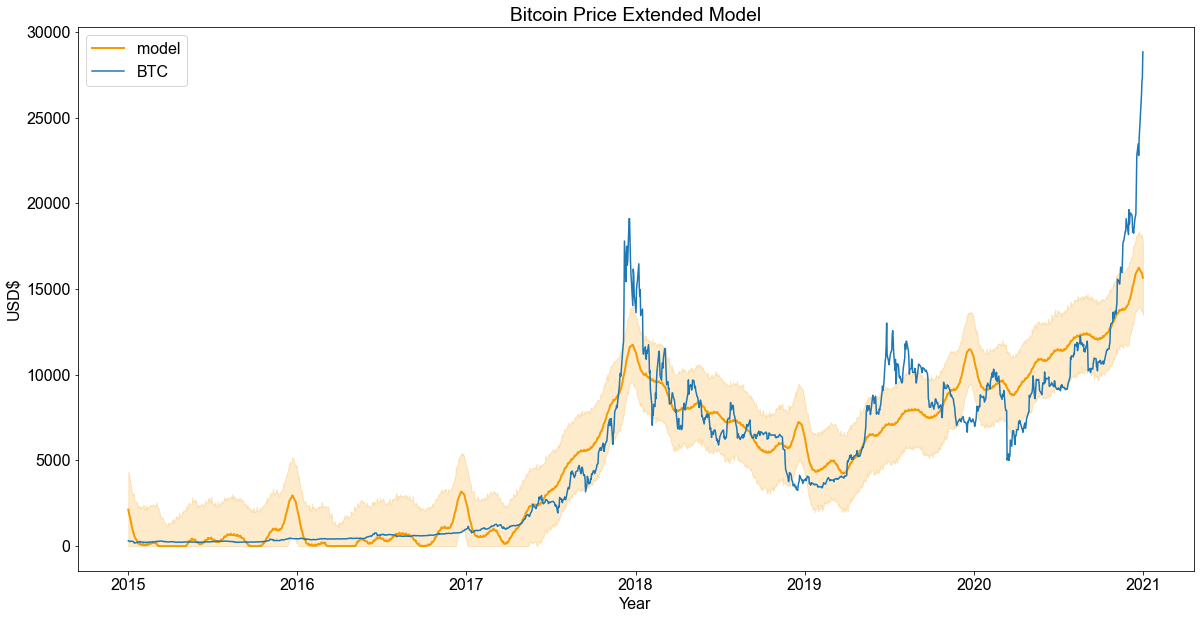

In [20]:
plt.rc("font", family="arial", size=16)

fig, ax = plt.subplots();
ax.plot(train_forecast["ds"], train_forecast["yhat"], linewidth=2, color="#F59B00", label="model")
ax.plot(train_forecast["ds"], input_df["y"], label="BTC")
plt.fill_between(train_forecast["ds"], train_forecast["yhat_lower"], train_forecast["yhat_upper"], color="#F59B00", alpha=0.2)
plt.xlabel("Year");
plt.ylabel("USD$");
plt.title("Bitcoin Price Extended Model");
plt.legend();

In [21]:
print("Metrics on training set")
calculate_performance_metrics(train_forecast.loc[:, "yhat"], input_df["y"])

Metrics on training set
Explained variance: 0.8469098008869775
RMSE: 1696.1926294833265


### Test set

Let's now predict after the `PREDICTION_CUTOFF` date. 

In [22]:
forecast = init_model.predict(future_df)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(15)

,ds,yhat,yhat_lower,yhat_upper
14,2021-01-25,13796.435178,11607.409378,16053.794994
15,2021-01-26,13864.010947,11674.429470,16083.565294
16,2021-01-27,13845.167292,11693.039296,15989.855755
17,2021-01-28,13798.074219,11567.369479,15915.380805
18,2021-01-29,13802.438424,11701.251220,15988.184818
19,2021-02-01,13834.358001,11626.000483,16051.850673
20,2021-02-02,13911.330267,11812.615500,15983.487964
21,2021-02-03,13899.700551,11819.175315,15925.216365
22,2021-02-04,13858.184417,11705.955659,16203.876752
23,2021-02-05,13867.026249,11723.033196,16202.546774


From the above, at most, Bitcoin's price is slightly above USD$16,000 in the test time period (given by `yhat_upper`).

In [23]:
print("Metrics on test set")
calculate_performance_metrics(forecast.loc[:, "yhat"], future_df["y"])

Metrics on test set
Explained variance: -2963.383486787013
RMSE: 22936.084237754658


The explained variance completely breaks down towards the end of January compared to the current price of Bitcoin (which is near USD$50,000 as of the writing of this report).

## Adding Regressors

We can improve our estimates by factoring in additional information i.e., *additional regressors*, to help with predicting the price of Bitcoin. Additional information we can factor are
* the number of unique addresses
* the difficulty of mining as time progresses
* the hash rate
* the total number of bitcoins in circulation
* the S&P 500 index value
* the US 13 week Treasury Bill rate
* the number of transactions excluding popular addresses
* the average block size in MB
* search trend sentiment from [Google Trends](https://trends.google.com/trends)

Let's look at the correlation of these regressors to the price via the correlation over the whole dataset period.

In [24]:
btc_features.corr()["Open"]

Open                              1.000000
Addresses                         0.693775
Difficulty                        0.747612
Hash_Rate                         0.755237
Total_Bitcoins                    0.700928
SnP500                            0.847504
TBill                             0.145437
Transactions_Excluding_Popular    0.491946
Average_Block_Size_MB             0.624521
Interest                          0.749824
Name: Open, dtype: float64

Note that correlation here is computed over the entire dataset. It is far more instructive to look at correlation over **rolling windows** instead. Here is an example of a 30-day rolling window correlation of the unique addresses to the Bitcoin open price.

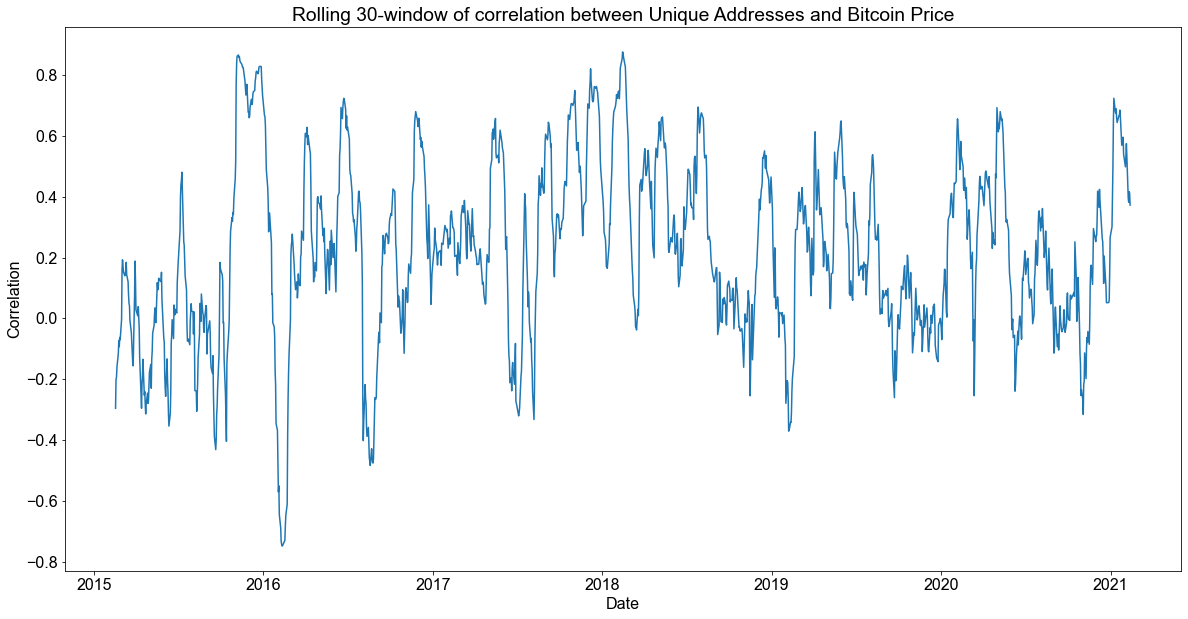

In [25]:
plt.rc("font", family="arial", size=16)

plt.plot(btc_features["Date"], btc_features["Open"].rolling(30).corr(btc_features["Addresses"]));
plt.title("Rolling 30-window of correlation between Unique Addresses and Bitcoin Price");
plt.xlabel("Date");
plt.ylabel("Correlation");

There are fluctuations in the correlations, but overall there is a positive correlation to the price.

The correlation to the price would mean that the regressors have some information that could help with the Bitcoin price prediction.

In [26]:
input_df = btc_features[
    [
        "Date", 
        "Open", 
        "Addresses", 
        "Difficulty", 
        "Hash_Rate", 
        "Total_Bitcoins", 
        "SnP500", 
        "TBill", 
        "Transactions_Excluding_Popular",
        "Average_Block_Size_MB",
        "Interest",
    ]
]
input_df = input_df.rename(columns={
    "Date": "ds", 
    "Open": "y", 
    "Addresses": "addresses",
    "Difficulty": "difficulty",
    "Hash_Rate": "hash_rate",
    "Total_Bitcoins": "total_bitcoins",
    "SnP500": "snp500",
    "TBill": "t_bill",
    "Transactions_Excluding_Popular": "transactions_excluding_popular",
    "Average_Block_Size_MB": "average_block_size_mb",
    "Interest": "interest",
})

future_df = input_df[input_df["ds"] >= PREDICTION_CUTOFF]
input_df = input_df[input_df["ds"] < PREDICTION_CUTOFF]

Note that we assume that these regressors are **additive** in nature to the model. There is no basis for this, and certainly some of these regressors could have **multiplicative** effects.  

In [27]:
extended_model = Prophet(daily_seasonality=False)

for col in input_df.columns:
    if col not in ["ds", "y"]:
        extended_model.add_regressor(col, mode="additive")

extended_model.fit(input_df);

In [28]:
train_forecast = extended_model.predict(input_df)

In [29]:
# set all non-negative early price forecasts to 0
set_nonnegative_forecasts(train_forecast)

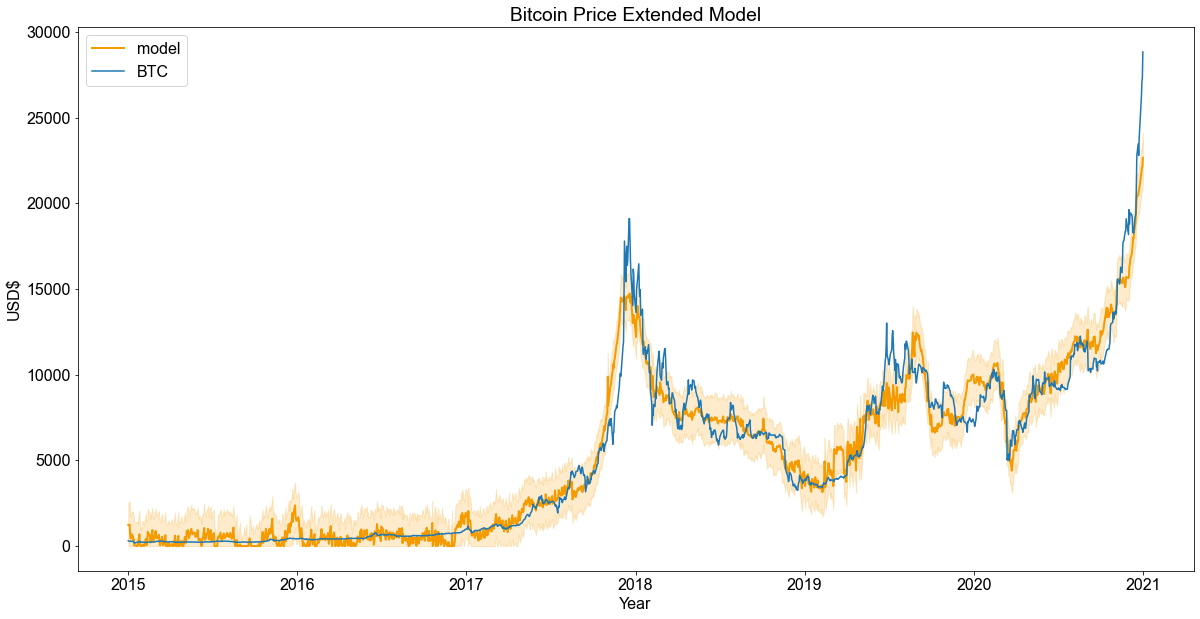

In [30]:
plt.rc("font", family="arial", size=16)

fig, ax = plt.subplots();
ax.plot(train_forecast["ds"], train_forecast["yhat"], linewidth=2, color="#F59B00", label="model")
ax.plot(train_forecast["ds"], input_df["y"], label="BTC")
plt.fill_between(train_forecast["ds"], train_forecast["yhat_lower"], train_forecast["yhat_upper"], color="#F59B00", alpha=0.2)
plt.xlabel("Year");
plt.ylabel("USD$");
plt.title("Bitcoin Price Extended Model");
plt.legend();

Again, we can see a huge departure from the model towards the end of 2020. But we can also see that the explained variance is much higher as compared to our initial model. Moreover, the uncertainty around the forecast `yhat` has reduced significantly.

In [31]:
print("Metrics on training set")
calculate_performance_metrics(train_forecast.loc[:, "yhat"], input_df["y"])

Metrics on training set
Explained variance: 0.9485043957769365
RMSE: 1046.708997483654


In [32]:
forecast = extended_model.predict(future_df)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(15)

,ds,yhat,yhat_lower,yhat_upper
14,2021-01-25,21300.016013,19839.327493,22624.243322
15,2021-01-26,21486.488002,20109.367148,22773.503730
16,2021-01-27,21358.056572,20085.653910,22641.199480
17,2021-01-28,21294.452767,19940.594717,22634.017432
18,2021-01-29,21208.523572,19794.766324,22621.028649
19,2021-02-01,21377.078782,19989.495013,22687.328463
20,2021-02-02,21416.695462,20108.508778,22707.194793
21,2021-02-03,21838.708919,20393.398100,23216.685319
22,2021-02-04,21890.205177,20520.643092,23272.412744
23,2021-02-05,22394.454504,21101.633579,23845.117370


From the above, at most, Bitcoin's price is slightly above USD$20,000 in the test time period (given by `yhat_upper`). Below, we see that the explained variance completely breaks down towards the end of January.

In [33]:
print("Metrics on test set")
calculate_performance_metrics(forecast.loc[:, "yhat"], future_df["y"])

Metrics on test set
Explained variance: -857.6812329475617
RMSE: 15282.667785947284


How would you use this in practice? In practice, one would have to make a forecast of these regressors and input them into the model. Now, this would be good if the regressors have **very good models readily available**, for example, weather forecasting models, or physics models, where their accuracy is often quite good.

Another way is to find regressors that are **leading indicators** of the quantity to be predicted. Then the information can be used to make a good forecast.

### Decomposition

Prophet can decompose the underlying trends of the price as a function of time. 

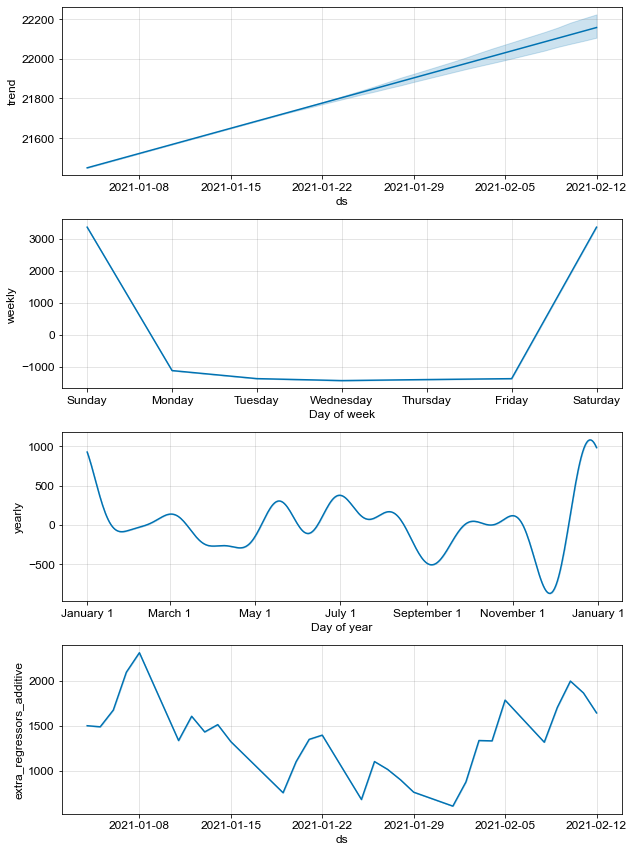

In [34]:
plt.rc("font", family="arial", size=12)
fig = extended_model.plot_components(forecast)

According to the extended model, it is better to buy Bitcoin between Wednesdays and Fridays, as the price peaks on the weekend. Moreover, prices are higher in early January than other months.

# Bonus: Ethereum Price Model

We can apply the concept to forecasting Ethereum price too. We now start from the 1st of January 2016 instead, as Ethereum's history is not as long as Bitcoin's.

In [35]:
START_DATE = "2016-01-01"

In [36]:
eth = pd.read_csv(os.path.join(BASE_DIR, "ETH_USD.csv"))
eth["Date"] = pd.to_datetime(eth["Date"], format="%Y-%m-%d")

In [37]:
eth_addresses = pd.read_csv(os.path.join(BASE_DIR, "eth_active_addresses_daily.csv"))
eth_addresses["Date"] = pd.to_datetime(eth_addresses["Date"], format="%m/%d/%Y")
eth_addresses = eth_addresses.loc[eth_addresses["Date"] >= START_DATE]

In [38]:
# Google Trends worldwide sentiment about Ethereum (Topic)
eth_google_trends_sentiment = pd.read_csv(os.path.join(BASE_DIR, "Google_ETH_interest.csv"))
eth_google_trends_sentiment = clean_google_trends_data(eth_google_trends_sentiment, START_DATE, eth["Date"].max())

In [39]:
additional_regressors = [
    eth_addresses,
    eth_google_trends_sentiment,
]

eth_features = eth[["Date", "24h Open (USD)"]]
for regressor in additional_regressors:
    eth_features = eth_features.merge(regressor, on="Date")
eth_features.dropna(inplace=True)

## Ethereum Price Model

We use the total unique addresses the Ethereum network has as a regressor for our model.

In [40]:
input_df = eth_features[
    [
        "Date", 
        "24h Open (USD)", 
        "Unique Address Total Count",
        "Interest",
    ]
]
input_df = input_df.rename(columns={
    "Date": "ds", 
    "24h Open (USD)": "y", 
    "Unique Address Total Count": "addresses",
    "Interest": "interest"
})

future_df = input_df[input_df["ds"] >= PREDICTION_CUTOFF]
input_df = input_df[input_df["ds"] < PREDICTION_CUTOFF]

In [41]:
eth_model = Prophet(daily_seasonality=False)
eth_model.add_regressor("addresses", mode="additive")
eth_model.add_regressor("interest", mode="additive")

eth_model.fit(input_df);

In [42]:
eth_train_forecast = eth_model.predict(input_df)

In [43]:
# set all non-negative early price forecasts to 0
set_nonnegative_forecasts(eth_train_forecast)

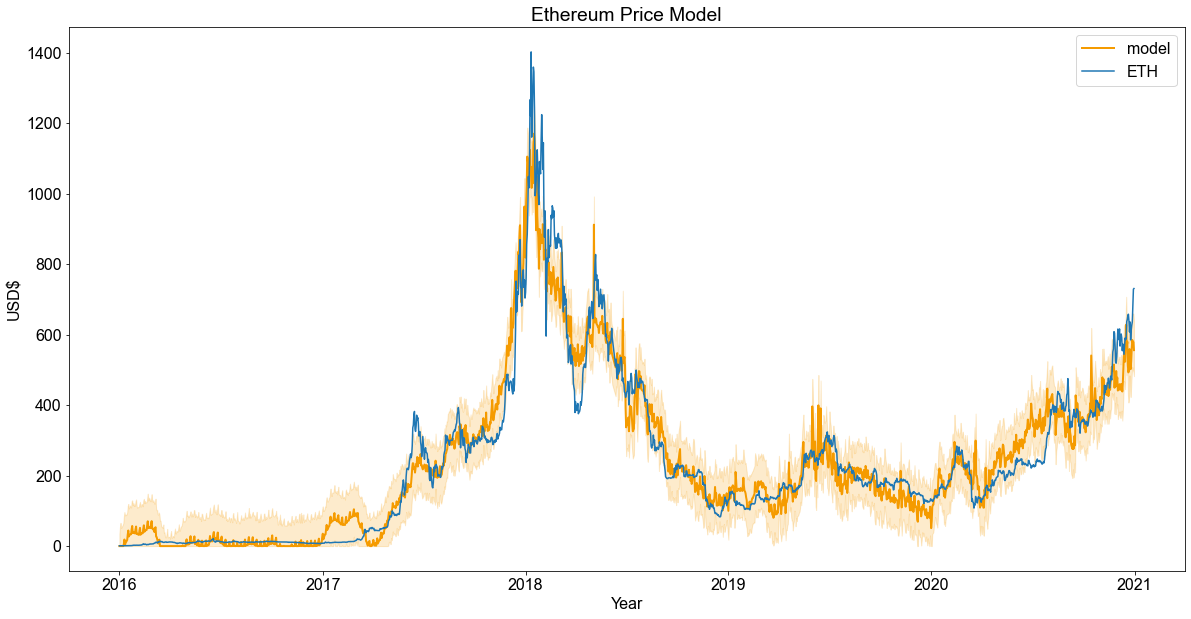

In [44]:
plt.rc("font", family="arial", size=16)

fig, ax = plt.subplots();
ax.plot(eth_train_forecast["ds"], eth_train_forecast["yhat"], linewidth=2, color="#F59B00", label="model")
ax.plot(eth_train_forecast["ds"], input_df["y"], label="ETH")
plt.fill_between(eth_train_forecast["ds"], eth_train_forecast["yhat_lower"], eth_train_forecast["yhat_upper"], color="#F59B00", alpha=0.2)
plt.xlabel("Year");
plt.ylabel("USD$");
plt.title("Ethereum Price Model");
plt.legend();

In [45]:
print("Metrics on training set")
calculate_performance_metrics(eth_train_forecast.loc[:, "yhat"], input_df["y"])

Metrics on training set
Explained variance: 0.9219897053172779
RMSE: 61.08560677575002


In [46]:
eth_forecast = eth_model.predict(future_df)
eth_forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(15)

,ds,yhat,yhat_lower,yhat_upper
28,2021-01-29,753.924372,672.293298,835.552225
29,2021-01-30,736.533824,655.911423,813.475773
30,2021-01-31,721.220890,639.396954,803.666763
31,2021-02-01,723.577848,640.433260,806.874341
32,2021-02-02,745.103035,667.053787,828.550539
33,2021-02-03,774.696372,692.855803,851.904371
34,2021-02-04,758.785530,679.214248,840.978242
35,2021-02-05,744.954675,667.107631,827.134868
36,2021-02-06,736.672126,654.669415,818.248984
37,2021-02-07,742.510846,665.613684,823.861216


In [47]:
print("Metrics on test set")
calculate_performance_metrics(eth_forecast.loc[:, "yhat"], future_df["y"])

Metrics on test set
Explained variance: -195.72659616846983
RMSE: 622.4602121564476


Again, current prices has departed from the model prediction as of the development of this notebook.

### Decomposition 

Here, we decompose the price action of Ethereum.

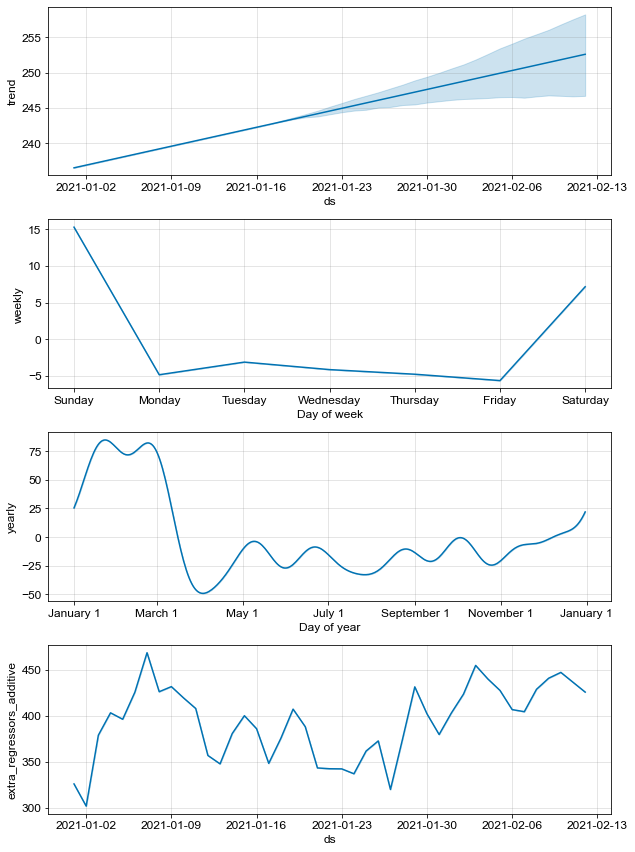

In [48]:
plt.rc("font", family="arial", size=12)
fig = eth_model.plot_components(eth_forecast)

The observations here are the same as that for Bitcoin. Prices tend to be higher from early January to March.

# Conclusion

Predicting prices of an asset is highly challenging. If we assume our model to be a predictor of the intrinsic value of Bitcoin and Ethereum, then both these cryptocurrencies are overvalued towards the end of January and well into February 2021. We will not go into a discourse on the concept of value with respect to cryptocurrencies. We shall only mention that our model shows that the current price action is a large departure from what is expected based on Prophet's model assumptions, together with the additional information provided by regressors.

We have also shown that using regressors that are correlated to the price is a good way to improve the performance of the prediction. We see that the regressors have increased the explained variance of the model over the baseline model.

Here are several issues to consider:
* **price non-negativity**: Prophet at present does not provide a facility to factor in constraints on the time series to be forecasted. We know that price is at least $0, but Prophet does not allow for this prior information without some modifications to the underlying code (see [here](https://github.com/facebook/prophet/issues/1405) and [here](https://github.com/alexander-pv/prophet/blob/develop/test_constrained_model.ipynb) for example).
* **multiplicative regressors**: we assume all regressors are additive. It will take more work and rigourous cross-validation to determine which regressors are potentially multiplicative.
* **ceiling on coins in circulation**: Bitcoin is unique in that there is ultimately a ceiling on the number of Bitcoins there could ever be: exactly 21 million. We could improve our model by including this constraint into our model.